# 1. Imports

In [21]:
import pandas as pd
from pathlib import Path

import numpy as np

from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

from scipy import sparse
import joblib

DATA_PATH = Path("../data/")
DATA_OUTPUT_PATH = Path("../output/")

# 2. Load Data

In [22]:
# Load sparse TF-IDF matrices and vectorizer
X_train_text = sparse.load_npz(f"{DATA_PATH}/tfidf/X_train_tfidf.npz") # Load training TF-IDF matrix
X_test_text  = sparse.load_npz(f"{DATA_PATH}/tfidf/X_test_tfidf.npz") # Load testing TF-IDF matrix
vectorizer   = joblib.load(f"{DATA_PATH}/tfidf/tfidf_vectorizer.pkl") # Load TF-IDF vectorizer

In [23]:
df_nvidia = pd.read_csv(DATA_PATH / "NVIDIA_Merged_20231101-Present.csv")

df_nvidia['date'] = pd.to_datetime(df_nvidia['date'])
display(df_nvidia.head())

,language,sourcecountry,seendate,date,url,title,domain,open,high,low,close,adj_close,volume
0,English,United States,2023-11-01 00:00:00+00:00,2023-11-01,https://www.insidermonkey.com/blog/5-uncommon-...,5 Uncommon ETFs in Which to Invest - Insider M...,insidermonkey.com,40.88,42.38,40.87,42.33,42.3,437593000
1,English,United States,2023-11-01 01:30:00+00:00,2023-11-01,https://www.marketwatch.com/story/amd-makes-bo...,Opinion : AMD makes bold prediction for its AI...,marketwatch.com,40.88,42.38,40.87,42.33,42.3,437593000
2,English,United States,2023-11-01 10:00:00+00:00,2023-11-01,https://www.fool.com/investing/2023/11/01/wher...,Where Will Nvidia Be in 1 Year ? | The Motley ...,fool.com,40.88,42.38,40.87,42.33,42.3,437593000
3,English,NaN,2023-11-01 10:15:00+00:00,2023-11-01,https://biztoc.com/x/2cd3129762787d99,"AMD forecasts $2 billion sales of AI chips , h...",biztoc.com,40.88,42.38,40.87,42.33,42.3,437593000
4,English,United States,2023-11-01 17:45:00+00:00,2023-11-01,https://www.myrtlebeachonline.com/news/busines...,AMD slides as muted outlook clouds Q3 earnings...,myrtlebeachonline.com,40.88,42.38,40.87,42.33,42.3,437593000


In [24]:
SPLIT_DATE = pd.Timestamp("2025-10-01")

train_df = df_nvidia[df_nvidia["date"] < SPLIT_DATE].copy()
test_df  = df_nvidia[df_nvidia["date"] >= SPLIT_DATE].copy()

# One close per day (you can use .first(), .last(), or .mean())
train_daily = (
    train_df.groupby("date")["close"]
    .first()
    .reset_index()
    .sort_values("date")
)

test_daily = (
    test_df.groupby("date")["close"]
    .first()
    .reset_index()
    .sort_values("date")
)

train_dates = train_daily["date"].values
test_dates  = test_daily["date"].values

y_train_all = train_daily["close"].values   # one close per train day
y_test_all  = test_daily["close"].values    # one close per test day

# Checking number of days must match TF-IDF rows
print("X_train_text shape:", X_train_text.shape)
print("train_daily days:", len(train_dates))
print("X_test_text shape:", X_test_text.shape)
print("test_daily days:", len(test_dates))

X_train_text shape: (447, 50)
train_daily days: 447
X_test_text shape: (38, 50)
test_daily days: 38


# 2.1. Iterative forecast function

In [25]:
def iterative_forecast(model, X_test_text, y_train_all, test_dates):
    """
    model: trained on [TFIDF(t), Close(t)] → Close(t+1)
    X_test_text: TFIDF for each test day, in order
    y_train_all: array of all *train* closes (used to seed prev_close)
    test_dates: array of dates for the test period
    """
    predicted_closes = []

    # Start with last *actual* training close
    prev_close = float(y_train_all[-1])

    for i in range(len(test_dates)):
        # (1, 1) dense feature for prev_close
        prev_close_feat = np.array([[prev_close]])

        # (1, n_features+1): [TFIDF(test_day_i), prev_close]
        X_i = hstack([X_test_text[i, :], prev_close_feat])

        # Predict close for this test day
        y_pred_i = float(model.predict(X_i)[0])
        predicted_closes.append(y_pred_i)

        # Next day uses this day's predicted close
        prev_close = y_pred_i

    return np.array(predicted_closes)

# 2.2. Evaluation metric function

In [26]:
def build_forecast_df(preds, test_dates, y_test_all, model_name="Model", add_summary_row=True):
    """
    preds        : array-like, predicted closes for each test date
    test_dates   : array-like of datetime-like values
    y_test_all   : array-like, actual closes for each test date
    model_name   : name for printing/logging
    add_summary_row : if True, appends a final 'METRICS' row
    """
    preds = np.asarray(preds)
    y_test_all = np.asarray(y_test_all)

    # Base prediction table
    pred_df = pd.DataFrame({
        "date": test_dates,
        "dayofweek": [pd.Timestamp(d).day_name() for d in test_dates],
        "predicted_close": preds,
        "actual_close": y_test_all,
    }).set_index("date")

    # Metrics
    rmse = mean_squared_error(y_test_all, preds)
    mae  = mean_absolute_error(y_test_all, preds)
    r2   = r2_score(y_test_all, preds)

    metrics = {
        "model": model_name,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

    # Pretty print
    print(f"\n=== {model_name} (iterative forecast) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}")

    return pred_df, metrics

# 3. Further Data Preprocessing for Iterative Prediction

To predict close(t), you must use only information available at the end of day (t-1).

- TFIDF_day1 & closing_day1_price → predicts closing_day2_price
- TFIDF_day2 & closing_day2_price → predicts closing_day3_price

For example: If our data looks like this. 
| Day | Date       | TF-IDF Vector (simplified) | Close |
| --- | ---------- | -------------------------- | ----- |
| 1   | 2025-10-01 | `[0.2, 0.1, 0.0]`          | 100   |
| 2   | 2025-10-02 | `[0.4, 0.0, 0.1]`          | 102   |
| 3   | 2025-10-03 | `[0.3, 0.2, 0.1]`          | 101   |
| 4   | 2025-10-04 | `[0.1, 0.4, 0.3]`          | 103   |


We first need to get every TFIDF except the last day (since last day's TFIDF isn't used for anything in terms of training.) Last day's of training TFIDF should be used as the TFIDF going into predicting the test.
| Row | Source Day | TF-IDF(t−1)       |
| --- | ---------- | ----------------- |
| 0   | Day 1      | `[0.2, 0.1, 0.0]` |
| 1   | Day 2      | `[0.4, 0.0, 0.1]` |
| 2   | Day 3      | `[0.3, 0.2, 0.1]` |

Get the values of the close price on that TFIDF day (`prev_close_train`)
| Row | Close(t−1) |
| --- | ---------- |
| 0   | 100        |
| 1   | 102        |
| 2   | 101        |

Get the value that we are predicting for (`y_train`)
| Row | Close(t) |
| --- | -------- |
| 0   | 102      |
| 1   | 101      |
| 2   | 103      |

Merge (`X_train_iter`)
| Row | TF-IDF(t−1)       | Close(t−1) | → Predict |
| --- | ----------------- | ---------- | --------- |
| 0   | `[0.2, 0.1, 0.0]` | `100`      | `102`     |
| 1   | `[0.4, 0.0, 0.1]` | `102`      | `101`     |
| 2   | `[0.3, 0.2, 0.1]` | `101`      | `103`     |





In [27]:
# TF-IDF(t-1): drop the last TF-IDF row
X_train_tfidf_prev = X_train_text[:-1]          # days 0..N-2

# Close(t-1): drop the last close
prev_close_train = y_train_all[:-1].reshape(-1, 1)

# Target Close(t): drop the first close
y_train = y_train_all[1:]                  # days 1..N-1

# Final training features: [TFIDF(t-1), Close(t-1)]
X_train_iter = hstack([X_train_tfidf_prev, prev_close_train])

# 4. Training & Prediction (Ridge Regression)

In [28]:
model = Ridge(alpha=1.0)
model.fit(X_train_iter, y_train)

ridge_pred = []

# Start with last *actual* training close
prev_close = float(y_train_all[-1])

for i in range(len(test_dates)):
    prev_close_feat = np.array([[prev_close]])  # shape (1,1)
    X_i = hstack([X_test_text[i, :], prev_close_feat])  # (1, n_features+1)

    y_pred_i = model.predict(X_i)[0]
    ridge_pred.append(y_pred_i)

    # For next day, feed in today's predicted close
    prev_close = y_pred_i

In [29]:
ridge_df, ridge_metrics = build_forecast_df(ridge_pred, test_dates, y_test_all, "Ridge")
display(ridge_df)


=== Ridge (iterative forecast) ===
RMSE: 72.7241
MAE : 6.3096
R^2 : -0.2246


,dayofweek,predicted_close,actual_close
date,,,
2025-10-01,Wednesday,186.527697,187.24
2025-10-02,Thursday,186.475449,188.89
2025-10-03,Friday,186.423934,187.62
2025-10-06,Monday,186.372280,185.54
2025-10-07,Tuesday,186.320902,185.04
2025-10-08,Wednesday,186.269712,189.11
2025-10-09,Thursday,186.219016,192.57
2025-10-10,Friday,186.169202,183.16
2025-10-13,Monday,186.119257,188.32


# 5. Model Logic (Random Forest Regressor)

In [30]:
# Base model
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid (you can tweak these)
rf_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Grid search with 3-fold CV
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# 6. Training & Prediction (Random Forest Regressor)

In [31]:
# Fit on training data
rf_grid.fit(X_train_iter, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV RMSE:", np.sqrt(-rf_grid.best_score_))

# Evaluate on test set
rf_best = rf_grid.best_estimator_
predicted_closes_rf = iterative_forecast(rf_best, X_test_text, y_train_all, test_dates)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF CV RMSE: 39.26704198220422


In [32]:
rf_df, rf_metrics = build_forecast_df(predicted_closes_rf, test_dates, y_test_all, "Random Forest")
display(rf_df)


=== Random Forest (iterative forecast) ===
RMSE: 3266.8829
MAE : 56.5961
R^2 : -54.0107


,dayofweek,predicted_close,actual_close
date,,,
2025-10-01,Wednesday,155.993985,187.24
2025-10-02,Thursday,135.176949,188.89
2025-10-03,Friday,133.282615,187.62
2025-10-06,Monday,124.078731,185.54
2025-10-07,Tuesday,125.667357,185.04
2025-10-08,Wednesday,129.532572,189.11
2025-10-09,Thursday,131.886975,192.57
2025-10-10,Friday,138.839172,183.16
2025-10-13,Monday,138.590019,188.32


# 7. Model Logic (XGBoost)

In [33]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    tree_method="hist"
)

xgb.fit(X_train_iter, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# 8. Training & Prediction (Random Forest Regressor)

In [34]:
xgb_preds = iterative_forecast(xgb, X_test_text, y_train_all, test_dates)
xgb_df, xgb_metrics = build_forecast_df(xgb_preds, test_dates, y_test_all, "XGBoost")
display(xgb_df)


=== XGBoost (iterative forecast) ===
RMSE: 2450.8565
MAE : 47.5983
R^2 : -40.2697


,dayofweek,predicted_close,actual_close
date,,,
2025-10-01,Wednesday,175.065689,187.24
2025-10-02,Thursday,172.197372,188.89
2025-10-03,Friday,163.909424,187.62
2025-10-06,Monday,150.502106,185.54
2025-10-07,Tuesday,144.113129,185.04
2025-10-08,Wednesday,142.911758,189.11
2025-10-09,Thursday,140.657120,192.57
2025-10-10,Friday,146.083252,183.16
2025-10-13,Monday,148.496323,188.32


# 9. Results & Discussion

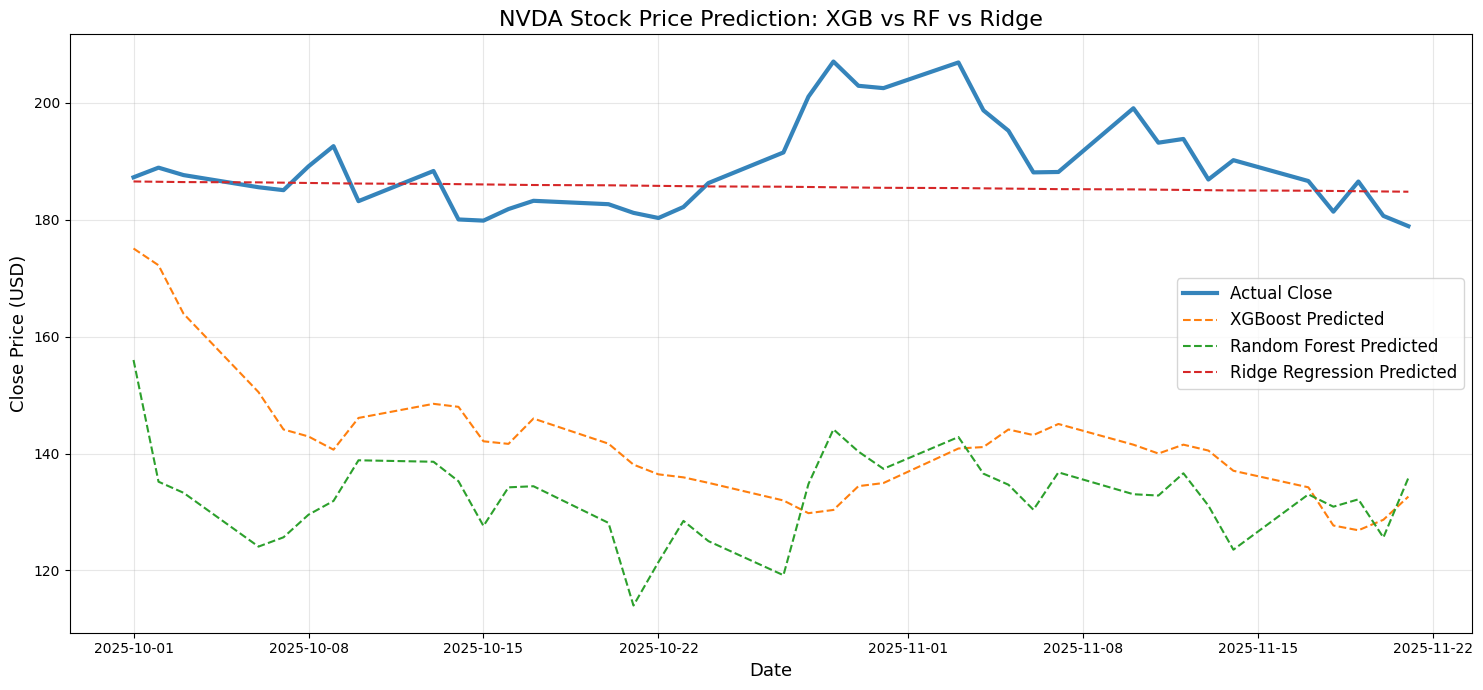

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot actual close price
plt.plot(
    xgb_df.index,
    xgb_df["actual_close"],
    label="Actual Close",
    linewidth=3,
    linestyle="-",
    alpha=0.9
)

# Plot model predictions
plt.plot(
    xgb_df.index,
    xgb_df["predicted_close"],
    label="XGBoost Predicted",
    linestyle="--"
)

plt.plot(
    rf_df.index,
    rf_df["predicted_close"],
    label="Random Forest Predicted",
    linestyle="--"
)

plt.plot(
    ridge_df.index,
    ridge_df["predicted_close"],
    label="Ridge Regression Predicted",
    linestyle="--"
)

plt.title("NVDA Stock Price Prediction: XGB vs RF vs Ridge", fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Close Price (USD)", fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Across all three models (XGBoost, Random Forest, and Ridge Regression) the iterative next-day forecasting setup struggled to produce meaningful predictions for the October–November 2025 test period. Although the models learned a general downward trend from the training window, all of them systematically underpredicted the actual NVIDIA closing prices once they began generating autoregressive forecasts.

A key issue is that iterative forecasting forces each model to repeatedly feed its own predicted value back in as the next day’s input. This makes the prediction path extremely sensitive to early errors. Once the first few predictions drifted even slightly below the true prices, that error compounded, causing all three models to collapse into a persistent downward slide.

Additionally, the feature set was extremely limited: the TF-IDF representations of daily news headlines carry very weak directional price-movement signal, and only one lagged price feature was included. Without richer temporal, technical, or market features, the models lacked the ability to respond to the volatility and sudden price movements that characterized early–mid November 2025.

1. XGBoost produced the most reasonable prediction curve and the best numerical performance among the tree-based models. However, despite having the lowest RMSE and MAE of the two, it still drifted downward consistently and failed to capture the magnitude or variability of the true prices.
2. Random Forest performed the worst overall. Its predictions quickly diverged because RF struggles with high-dimensional sparse TF-IDF inputs and lacks the sequential inductive bias needed for autoregressive stock forecasting.
3. Ridge Regression, on the surface, appears to perform extremely well according to RMSE and MAE. However, this is misleading. As shown in the plot, Ridge essentially outputs a near-constant flat line. This artificially minimizes errors when the model predicts a value close to the overall mean of the training set. The low error metrics reflect the lack of variance not any genuine predictive power.